Replicate EV/REV plots for Octopamine/Rolipram sessions previously generated by Jahangir.

In [1]:
# Import all the functions you need
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from pathlib import Path
import platform

# Comment here to add in for either mac or linux computer
if platform.system() == "Linux":   # for linux
    sys.path.extend(['/data/GitHub/NeuroPy']) 
    sys.path.extend(['/data/GitHub/TraceFC/'])
    sys.path.extend(['/data/GitHub/sleep_loss_hippocampal_replay/analysis_and_figure_code/DataPaths'])
elif platform.system() == "Darwin":
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/TraceFC'])
elif platform.system() == "Windows":
    print('No windows repositories defined')

from neuropy.core.neurons import Neurons
from neuropy.analyses.reactivation import ExplainedVariance
from neuropy.core.epoch import Epoch
from neuropy.core.session import ProcessData
from neuropy.plotting import plot_epochs
from neuropy.utils.plot_util import match_axis_lims

import ev_utils

plot_save_dir = Path('/home/nkinsky/Dropbox (University of Michigan)/Shared_Folders/KD/Grants/R01_octopamine_rollipram/Nat_plots')

/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


### Set up colors and rough injection times (from Jahangir plots)

In [2]:
sesh_csv = "/data3/Octopamine_Rolipram/Recording_Rats/OCT_ROL_sessions.csv"
sesh_df = pd.read_csv(sesh_csv, header=0)
sesh_df['session'] = pd.Categorical(sesh_df['session'], ['PBS', 'SAL', 'ROL', 'OCT'])
sesh_df = sesh_df.sort_values(["Animal", "session"]).reset_index().drop(columns = "index")
sesh_df

,Animal,session,date,directory,processed,inject 1,inject 2,accuracy
0,A11,PBS,2019_12_02,/data3/Octopamine_Rolipram/Recording_Rats/A11/...,Y,4.8,6.3,guess
1,A11,ROL,2019_12_12,/data3/Octopamine_Rolipram/Recording_Rats/A11/...,Y,4.8,6.3,guess
2,A11,OCT,2019_11_30,/data3/Octopamine_Rolipram/Recording_Rats/A11/...,Y,4.8,6.3,guess
3,A14,PBS,2020_02_23,/data3/Octopamine_Rolipram/Recording_Rats/A14/...,Y,4.7,6.2,from_plot
4,A14,ROL,2020_02_26,/data3/Octopamine_Rolipram/Recording_Rats/A14/...,Y,5.0,6.5,from_plot
5,A14,OCT,2020_02_21,/data3/Octopamine_Rolipram/Recording_Rats/A14/...,Y,4.8,6.3,guess
6,BG,SAL,2019_10_21,/data3/Octopamine_Rolipram/Recording_Rats/BG/B...,Y,4.8,6.3,from_plot
7,BG,ROL,2019_10_19,/data3/Octopamine_Rolipram/Recording_Rats/BG/B...,Y,4.9,6.4,from_plot
8,BG,OCT,None,None,N,NaN,NaN,NaN
9,BGU,SAL,2021_08_11,/data3/Octopamine_Rolipram/Recording_Rats/BGU/...,Y,4.7,6.2,from_plot


In [3]:
colors_rs = "#5599ff"
colors_nsd = "k"
colors_sd = "#eb4034"
colors_maze = "g"
colors_pre = "#424242"
colors_sd_all = [colors_pre, colors_maze, colors_sd, colors_rs]

def adjust_lightness(color, amount=0.5):
    import colorsys

    import matplotlib.colors as mc

    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    c = colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])
    return mc.to_hex(c)

colors_all_light = [adjust_lightness(col, 1.2) for col in colors_sd_all]

### Run for all neurons

In [86]:
animal_df = sesh_df[sesh_df.Animal == "A14"]
rec_df = animal_df[animal_df.session == "OCT"]

dir_use = Path(str(rec_df["directory"].values[0]))
neurons_use = Neurons.load(sorted(dir_use.glob("*.neurons.npy"))[0])
neurons_use.get_neuron_type(['1', 'mua'])

Neurons
 n_neurons: 5
 t_start: 0.0
 t_stop: 48770.7
 neuron_type: ['1' 'mua']

In [14]:
np.concatenate((neurons_use.spiketrains, neurons_use.spiketrains), axis=0).shape

(18,)

In [69]:
neurons_use.neuron_type.dtype.kind

'U'

In [51]:
34*300+900

11100

In [58]:
121*300+900

37200

In [73]:
neurons_use

Neurons
 n_neurons: 9
 t_start: 0.0
 t_stop: 48770.7
 neuron_type: ['1' 'mua' 'pyr']

In [88]:
neurons_use.concatenate(neurons_use, index_to_add=100)

spiketrains with kind=O
neuron_ids with kind=i
neuron_type with kind=U
waveforms with kind=f
peak_channels with kind=i
shank_ids with kind=i


Neurons
 n_neurons: 18
 t_start: 0.0
 t_stop: 48770.7
 neuron_type: ['1' 'mua' 'pyr']

### Combine all into one session

In [166]:
pcorr_val, pcorr_labels = ev_utils.get_pcorr(neurons_use, epochs)
pcorr_val.shape

/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


(6697, 4)

996

In [168]:
p_corr = []
for e in epochs.itertuples():
    e_corr = neurons_use.time_slice(e.start, e.stop).get_binned_spiketrains(bin_size=0.25).get_pairwise_corr()
    p_corr.append(e_corr)

/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [171]:
np.array(p_corr).T.shape

(6786, 4)

In [175]:
(neurons_use.n_neurons)*(neurons_use.n_neurons - 1)/2

6786.0

In [167]:
e_corr = neurons_use.time_slice(e.start, e.stop).get_binned_spiketrains(bin_size=0.25).get_pairwise_corr()
e_corr.shape

(6786,)

In [78]:
[session in session_use for session in animal_df.session]

[False, False, True]

In [120]:
type(neurons_use.neuron_type[-1])

float

In [122]:
epochs.shift(-epochs["maze"].stops[0])

4 epochs
Snippet: 
    start   stop label
0 -14410  -3375   pre
1  -3374      0  maze
2      1  18500    sd
3  18501  36698  post

In [82]:
rec_df

,Animal,session,date,directory,processed,inject 1,inject 2,accuracy
0,A11,PBS,2019_12_02,/data3/Octopamine_Rolipram/Recording_Rats/A11/...,Y,4.8,6.3,guess


In [ ]:
## So to make this work, first divide set post start to zt 0 and divide into appropriate size bins (overlapping?).
# Then run pcorr for each animal individually and dump into a df
# Do the same for maze, fill in nans for times that don't have data points
# then do the same for pre
# then save into a dataframe and run ev_utils.get_ev

# Better is just to take a weighted average of all sessions

In [149]:
durations

[array([11035,  3374, 18499, 18197]),
 array([12245,  3336, 18125, 18425]),
 array([11011,  3088, 18835, 18194]),
 array([10924,  2838, 19661, 18433]),
 array([11045,  3930, 17600, 18857]),
 array([11813,  3795, 17798, 18198]),
 array([10948,  3148, 19176, 18921]),
 array([10923,  3831, 18166, 18158]),
 array([ 9954,  3316, 18252, 18137]),
 array([ 8726,  3979, 18069, 18067]),
 array([10862,  3012, 18064, 15373]),
 array([10831,  3632, 18197, 14611])]

In [148]:
durations = []
for animal, axrow, axepoch in zip(sesh_df.Animal.unique(), axs[1::2], axs[0::2]):
    animal_df = sesh_df[sesh_df.Animal == animal]
    for session, ax, axe in zip(animal_df.session, axrow, axepoch):
        rec_df = animal_df[animal_df.session == session]
        if (rec_df.directory.values[0] == "None") or (rec_df.processed.values[0] == "N"):
            pass
        else:
            dir_use = Path(str(rec_df["directory"].values[0]))
            neurons_use = Neurons.load(sorted(dir_use.glob("*.neurons.npy"))[0])
            # neurons_use = Neurons.from_dict(neurons_use)
            epochs = Epoch(epochs=None, file=sorted(dir_use.glob("*.epoch.npy"))[0])
            durations.append(epochs.durations)

In [90]:
session_use = ["PBS", "SAL"] 
for animal, axrow, axepoch in zip(sesh_df.Animal.unique()[[0]], axs[1::2], axs[0::2]):
    animal_df = sesh_df[sesh_df.Animal == animal]
    rec_df = animal_df[[session in session_use for session in animal_df.session]]
    if (rec_df.directory.values[0] == "None") or (rec_df.processed.values[0] == "N"):
        pass
    else:
        dir_use = Path(str(rec_df["directory"].values[0]))
        neurons_use = Neurons.load(sorted(dir_use.glob("*.neurons.npy"))[0])
        # neurons_use = Neurons.from_dict(neurons_use)
        epochs = Epoch(epochs=None, file=sorted(dir_use.glob("*.epoch.npy"))[0])

Running EV for A11 PBS session
Calculating partial correlations for 120 time windows


100%|█████████████████████████████████████████| 120/120 [00:20<00:00,  5.86it/s]


Running EV for A11 ROL session
Calculating partial correlations for 119 time windows


100%|█████████████████████████████████████████| 119/119 [00:21<00:00,  5.45it/s]


Running EV for A11 OCT session
Calculating partial correlations for 121 time windows


100%|█████████████████████████████████████████| 121/121 [00:20<00:00,  5.83it/s]


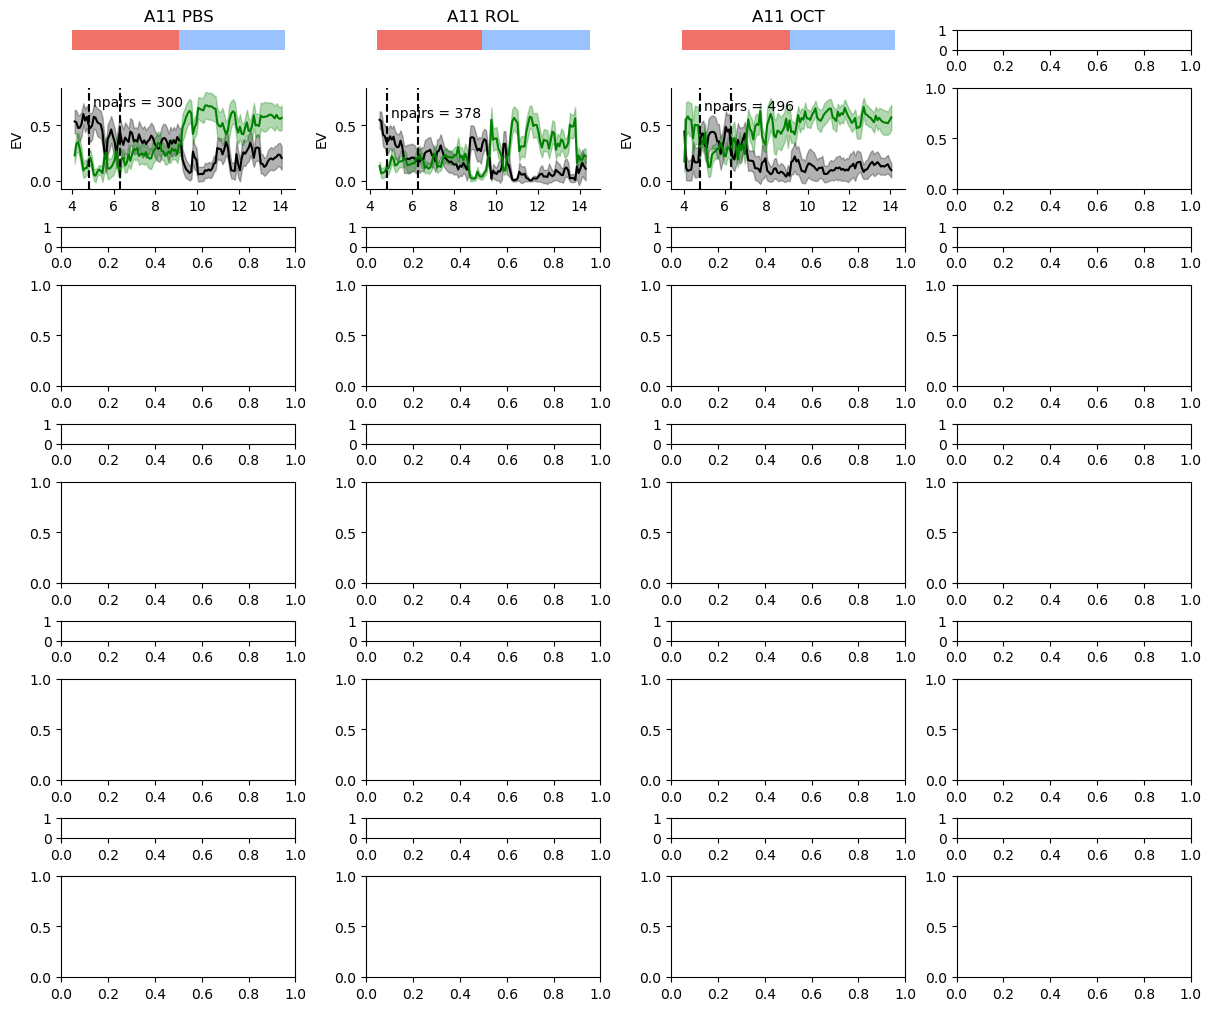

In [6]:
nanimals = len(sesh_df.Animal.unique())
# fig, axs = plt.subplots(nanimals, 4, figsize=(12, nanimals * 2), layout='tight')
fig, axs = plt.subplots(nanimals*2, 4, figsize=(12, nanimals * 2), height_ratios=[1, 5]*nanimals, layout='compressed')
plot_zeroed = False
ev_dict_all = {}
for animal, axrow, axepoch in zip(sesh_df.Animal.unique()[[0]], axs[1::2], axs[0::2]):
    animal_df = sesh_df[sesh_df.Animal == animal]
    axrow_used = []
    for session, ax, axe in zip(animal_df.session, axrow, axepoch):
        rec_df = animal_df[animal_df.session == session]
        if (rec_df.directory.values[0] == "None") or (rec_df.processed.values[0] == "N"):
            sns.despine(ax=ax, left=True, bottom=True)
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            dir_use = Path(str(rec_df["directory"].values[0]))
            neurons_use = Neurons.load(sorted(dir_use.glob("*.neurons.npy"))[0])
            # neurons_use = Neurons.from_dict(neurons_use)
            epochs = Epoch(epochs=None, file=sorted(dir_use.glob("*.epoch.npy"))[0])
            print(f"Running EV for {animal} {session} session")
            ev = ExplainedVariance(neurons_use, epochs['maze'].as_array().squeeze(), [epochs['sd'].starts[0], epochs['post'].stops[0]], 
                                   epochs['pre'].as_array().squeeze(), window=900, slideby=300, bin_size=0.250)
            ev_dict_all[f"{animal}_{session}"] = ev

            # Plot reactivation
            if not plot_zeroed:
                ax.plot(ev.matching_time/3600, ev.ev, 'k-')
                ax.plot(ev.matching_time/3600, ev.rev, 'g-')
                ax.fill_between(ev.matching_time/3600, ev.ev - ev.ev_std, ev.ev + ev.ev_std, color='k', alpha=0.3)
                ax.fill_between(ev.matching_time/3600, ev.rev - ev.rev_std, ev.rev + ev.rev_std, color='g', alpha=0.3)
                [ax.axvline(itime, linestyle="--", color="k") for itime in rec_df[["inject 1", "inject 2"]].values.squeeze()];
                ax.set_xticks([4, 6, 8, 10, 12, 14])
            else:
                ax.plot((ev.matching_time - ev.matching_time[0])/3600, ev.ev, 'k-')
                ax.plot((ev.matching_time - ev.matching_time[0])/3600, ev.rev, 'g-')
                ax.fill_between((ev.matching_time - ev.matching_time[0])/3600, ev.ev - ev.ev_std, ev.ev + ev.ev_std,
                                color='k', alpha=0.3)
                ax.fill_between((ev.matching_time - ev.matching_time[0])/3600, ev.rev - ev.rev_std, ev.rev + ev.rev_std, 
                                color='g', alpha=0.3)
                [ax.axvline(itime, linestyle="--", color="k") for itime in 
                 rec_df[["inject 1", "inject 2"]].values.squeeze() - ev.matching_time[0]/3600];
                ax.set_xticks([0, 2.5, 5, 7.5, 10])
            axe.set_title(f'{animal} {session}')
            
            ax.set_ylabel('EV')

            # Plot epochs
            if not plot_zeroed:
                plot_epochs(epochs[["sd", "post"]].scale(1/3600), collapsed=True, colors=colors_all_light[2:], ax=axe)
            else:
                epochs_zeroed = epochs[["sd", "post"]].scale(1/3600).shift(-epochs["sd"].scale(1/3600).starts[0])
                plot_epochs(epochs_zeroed, collapsed=True, colors=colors_all_light[2:], ax=axe)
            
            npairs = int(neurons_use.n_neurons*(neurons_use.n_neurons - 1) /2)
            ax.text(5, ax.get_ylim()[1]*0.8, f"npairs = {npairs}")
            sns.despine(ax=ax)
            sns.despine(ax=axe, left=True, bottom=True)
            axe.set_xticks([])
            axe.set_yticks([])
            
            axrow_used.append(ax)

            match_axis_lims([ax, axe], "x")

    # Match y limits on all EV plots in a row
    match_axis_lims(axrow_used, "y")

fig.savefig(plot_save_dir / "EV_all_neurons.pdf")

In [12]:
ev_dict_all['A11_OCT'].matching_time

array([14550.5, 14850.5, 15150.5, 15450.5, 15750.5, 16050.5, 16350.5,
       16650.5, 16950.5, 17250.5, 17550.5, 17850.5, 18150.5, 18450.5,
       18750.5, 19050.5, 19350.5, 19650.5, 19950.5, 20250.5, 20550.5,
       20850.5, 21150.5, 21450.5, 21750.5, 22050.5, 22350.5, 22650.5,
       22950.5, 23250.5, 23550.5, 23850.5, 24150.5, 24450.5, 24750.5,
       25050.5, 25350.5, 25650.5, 25950.5, 26250.5, 26550.5, 26850.5,
       27150.5, 27450.5, 27750.5, 28050.5, 28350.5, 28650.5, 28950.5,
       29250.5, 29550.5, 29850.5, 30150.5, 30450.5, 30750.5, 31050.5,
       31350.5, 31650.5, 31950.5, 32250.5, 32550.5, 32850.5, 33150.5,
       33450.5, 33750.5, 34050.5, 34350.5, 34650.5, 34950.5, 35250.5,
       35550.5, 35850.5, 36150.5, 36450.5, 36750.5, 37050.5, 37350.5,
       37650.5, 37950.5, 38250.5, 38550.5, 38850.5, 39150.5, 39450.5,
       39750.5, 40050.5, 40350.5, 40650.5, 40950.5, 41250.5, 41550.5,
       41850.5, 42150.5, 42450.5, 42750.5, 43050.5, 43350.5, 43650.5,
       43950.5, 4425

### Run for pyr neurons only

Running EV for A11 PBS sessions
Calculating partial correlations for 120 time windows


100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  7.04it/s]


Running EV for A11 ROL sessions
Calculating partial correlations for 119 time windows


100%|█████████████████████████████████████████| 119/119 [00:03<00:00, 34.70it/s]
/data/GitHub/NeuroPy/neuropy/analyses/reactivation.py:194: RuntimeWarning: Mean of empty slice
  self.ev = np.nanmean(partial_corr**2, axis=0)
/data/GitHub/NeuroPy/neuropy/analyses/reactivation.py:195: RuntimeWarning: Mean of empty slice
  self.rev = np.nanmean(rev_partial_corr**2, axis=0)
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Running EV for A11 OCT sessions
Calculating partial correlations for 121 time windows


100%|█████████████████████████████████████████| 121/121 [00:19<00:00,  6.06it/s]


Running EV for A14 PBS sessions
Calculating partial correlations for 124 time windows


100%|█████████████████████████████████████████| 124/124 [00:21<00:00,  5.69it/s]


Running EV for A14 ROL sessions
Calculating partial correlations for 119 time windows


100%|█████████████████████████████████████████| 119/119 [00:24<00:00,  4.95it/s]


Running EV for A14 OCT sessions
Calculating partial correlations for 117 time windows


100%|█████████████████████████████████████████| 117/117 [00:15<00:00,  7.42it/s]
/data/GitHub/NeuroPy/neuropy/analyses/reactivation.py:194: RuntimeWarning: Mean of empty slice
  self.ev = np.nanmean(partial_corr**2, axis=0)
/data/GitHub/NeuroPy/neuropy/analyses/reactivation.py:195: RuntimeWarning: Mean of empty slice
  self.rev = np.nanmean(rev_partial_corr**2, axis=0)
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Running EV for BG SAL sessions
Calculating partial correlations for 124 time windows


100%|█████████████████████████████████████████| 124/124 [00:21<00:00,  5.86it/s]


Running EV for BG ROL sessions
Calculating partial correlations for 119 time windows


100%|█████████████████████████████████████████| 119/119 [00:20<00:00,  5.82it/s]


Running EV for BGU SAL sessions
Calculating partial correlations for 119 time windows


100%|█████████████████████████████████████████| 119/119 [00:20<00:00,  5.84it/s]


Running EV for BGU ROL sessions
Calculating partial correlations for 118 time windows


100%|█████████████████████████████████████████| 118/118 [00:19<00:00,  6.11it/s]


Running EV for MR10 PBS sessions
Calculating partial correlations for 109 time windows


100%|█████████████████████████████████████████| 109/109 [00:18<00:00,  5.76it/s]


Running EV for MR10 ROL sessions
Calculating partial correlations for 107 time windows


100%|█████████████████████████████████████████| 107/107 [00:18<00:00,  5.83it/s]


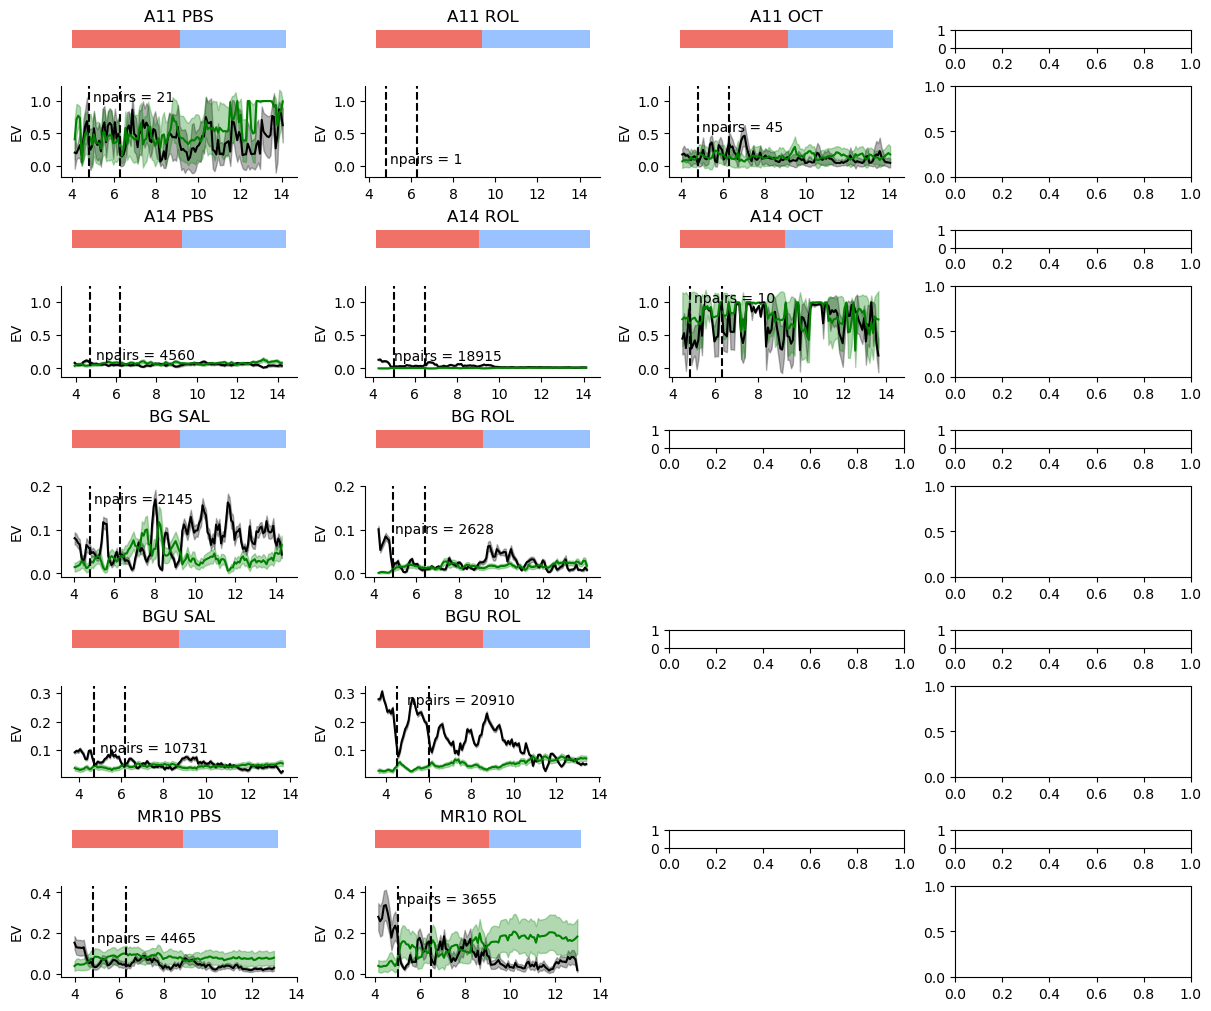

In [77]:
nanimals = len(sesh_df.Animal.unique())
# fig, axs = plt.subplots(nanimals, 4, figsize=(12, nanimals * 2), layout='tight')
fig, axs = plt.subplots(nanimals*2, 4, figsize=(12, nanimals * 2), height_ratios=[1, 5]*nanimals, layout='compressed')
plot_zeroed = False
ev_dict_all2 = {}
for animal, axrow, axepoch in zip(sesh_df.Animal.unique(), axs[1::2], axs[0::2]):
    animal_df = sesh_df[sesh_df.Animal == animal]
    axrow_used = []
    for session, ax, axe in zip(animal_df.session, axrow, axepoch):
        rec_df = animal_df[animal_df.session == session]
        if (rec_df.directory.values[0] == "None") or (rec_df.processed.values[0] == "N"):
            sns.despine(ax=ax, left=True, bottom=True)
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            dir_use = Path(str(rec_df["directory"].values[0]))
            neurons_use = Neurons.load(sorted(dir_use.glob("*.neurons.npy"))[0])
            neurons_use = neurons_use.get_neuron_type(["pyr", "good", "1"])
            
            epochs = Epoch(epochs=None, file=sorted(dir_use.glob("*.epoch.npy"))[0])
            print(f"Running EV for {animal} {session} sessions")
            ev = ExplainedVariance(neurons_use, epochs['maze'].as_array().squeeze(), [epochs['sd'].starts[0], epochs['post'].stops[0]], 
                                   epochs['pre'].as_array().squeeze(), window=900, slideby=300, bin_size=0.250)
            ev_dict_all2[f"{animal}_{session}"] = ev

            # Plot reactivation
            if not plot_zeroed:
                ax.plot(ev.matching_time/3600, ev.ev, 'k-')
                ax.plot(ev.matching_time/3600, ev.rev, 'g-')
                ax.fill_between(ev.matching_time/3600, ev.ev - ev.ev_std, ev.ev + ev.ev_std, color='k', alpha=0.3)
                ax.fill_between(ev.matching_time/3600, ev.rev - ev.rev_std, ev.rev + ev.rev_std, color='g', alpha=0.3)
                [ax.axvline(itime, linestyle="--", color="k") for itime in rec_df[["inject 1", "inject 2"]].values.squeeze()];
                ax.set_xticks([4, 6, 8, 10, 12, 14])
            else:
                ax.plot((ev.matching_time - ev.matching_time[0])/3600, ev.ev, 'k-')
                ax.plot((ev.matching_time - ev.matching_time[0])/3600, ev.rev, 'g-')
                ax.fill_between((ev.matching_time - ev.matching_time[0])/3600, ev.ev - ev.ev_std, ev.ev + ev.ev_std,
                                color='k', alpha=0.3)
                ax.fill_between((ev.matching_time - ev.matching_time[0])/3600, ev.rev - ev.rev_std, ev.rev + ev.rev_std, 
                                color='g', alpha=0.3)
                [ax.axvline(itime, linestyle="--", color="k") for itime in 
                 rec_df[["inject 1", "inject 2"]].values.squeeze() - ev.matching_time[0]/3600];
                ax.set_xticks([0, 2.5, 5, 7.5, 10])
            axe.set_title(f'{animal} {session}')
            
            ax.set_ylabel('EV')

            # Plot epochs
            if not plot_zeroed:
                plot_epochs(epochs[["sd", "post"]].scale(1/3600), collapsed=True, colors=colors_all_light[2:], ax=axe)
            else:
                epochs_zeroed = epochs[["sd", "post"]].scale(1/3600).shift(-epochs["sd"].scale(1/3600).starts[0])
                plot_epochs(epochs_zeroed, collapsed=True, colors=colors_all_light[2:], ax=axe)
            
            npairs = int(neurons_use.n_neurons*(neurons_use.n_neurons - 1) /2)
            ax.text(5, ax.get_ylim()[1]*0.8, f"npairs = {npairs}")
            sns.despine(ax=ax)
            sns.despine(ax=axe, left=True, bottom=True)
            axe.set_xticks([])
            axe.set_yticks([])
            
            axrow_used.append(ax)

            match_axis_lims([ax, axe], "x")

    # Match y limits on all EV plots in a row
    match_axis_lims(axrow_used, "y")

fig.savefig(plot_save_dir / "EV_pyr_only.pdf")

Running EV for A11 PBS session
Calculating partial correlations for 120 time windows


100%|█████████████████████████████████████████| 120/120 [00:17<00:00,  7.00it/s]


Running EV for A11 ROL session
Calculating partial correlations for 119 time windows


100%|█████████████████████████████████████████| 119/119 [00:03<00:00, 34.58it/s]
/data/GitHub/NeuroPy/neuropy/analyses/reactivation.py:194: RuntimeWarning: Mean of empty slice
  self.matching_time = np.mean(matching_windows, axis=1)
/data/GitHub/NeuroPy/neuropy/analyses/reactivation.py:195: RuntimeWarning: Mean of empty slice
  self.control_time = np.mean(control_windows, axis=1)
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Running EV for A11 OCT session
Calculating partial correlations for 121 time windows


100%|█████████████████████████████████████████| 121/121 [00:20<00:00,  5.87it/s]


Running EV for A14 PBS session
Calculating partial correlations for 124 time windows


100%|█████████████████████████████████████████| 124/124 [00:22<00:00,  5.44it/s]


Running EV for A14 ROL session
Calculating partial correlations for 119 time windows


100%|█████████████████████████████████████████| 119/119 [00:24<00:00,  4.86it/s]


Running EV for A14 OCT session
Calculating partial correlations for 117 time windows


100%|█████████████████████████████████████████| 117/117 [00:16<00:00,  7.30it/s]
/data/GitHub/NeuroPy/neuropy/analyses/reactivation.py:194: RuntimeWarning: Mean of empty slice
  self.matching_time = np.mean(matching_windows, axis=1)
/data/GitHub/NeuroPy/neuropy/analyses/reactivation.py:195: RuntimeWarning: Mean of empty slice
  self.control_time = np.mean(control_windows, axis=1)
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Running EV for BG SAL session
Calculating partial correlations for 124 time windows


100%|█████████████████████████████████████████| 124/124 [00:21<00:00,  5.74it/s]


Running EV for BG ROL session
Calculating partial correlations for 119 time windows


100%|█████████████████████████████████████████| 119/119 [00:20<00:00,  5.70it/s]


Running EV for BGU SAL session
Calculating partial correlations for 119 time windows


100%|█████████████████████████████████████████| 119/119 [00:20<00:00,  5.72it/s]


Running EV for BGU ROL session
Calculating partial correlations for 118 time windows


100%|█████████████████████████████████████████| 118/118 [00:19<00:00,  6.03it/s]


Running EV for MR10 PBS session
Calculating partial correlations for 109 time windows


100%|█████████████████████████████████████████| 109/109 [00:19<00:00,  5.66it/s]


Running EV for MR10 ROL session
Calculating partial correlations for 107 time windows


100%|█████████████████████████████████████████| 107/107 [00:18<00:00,  5.70it/s]


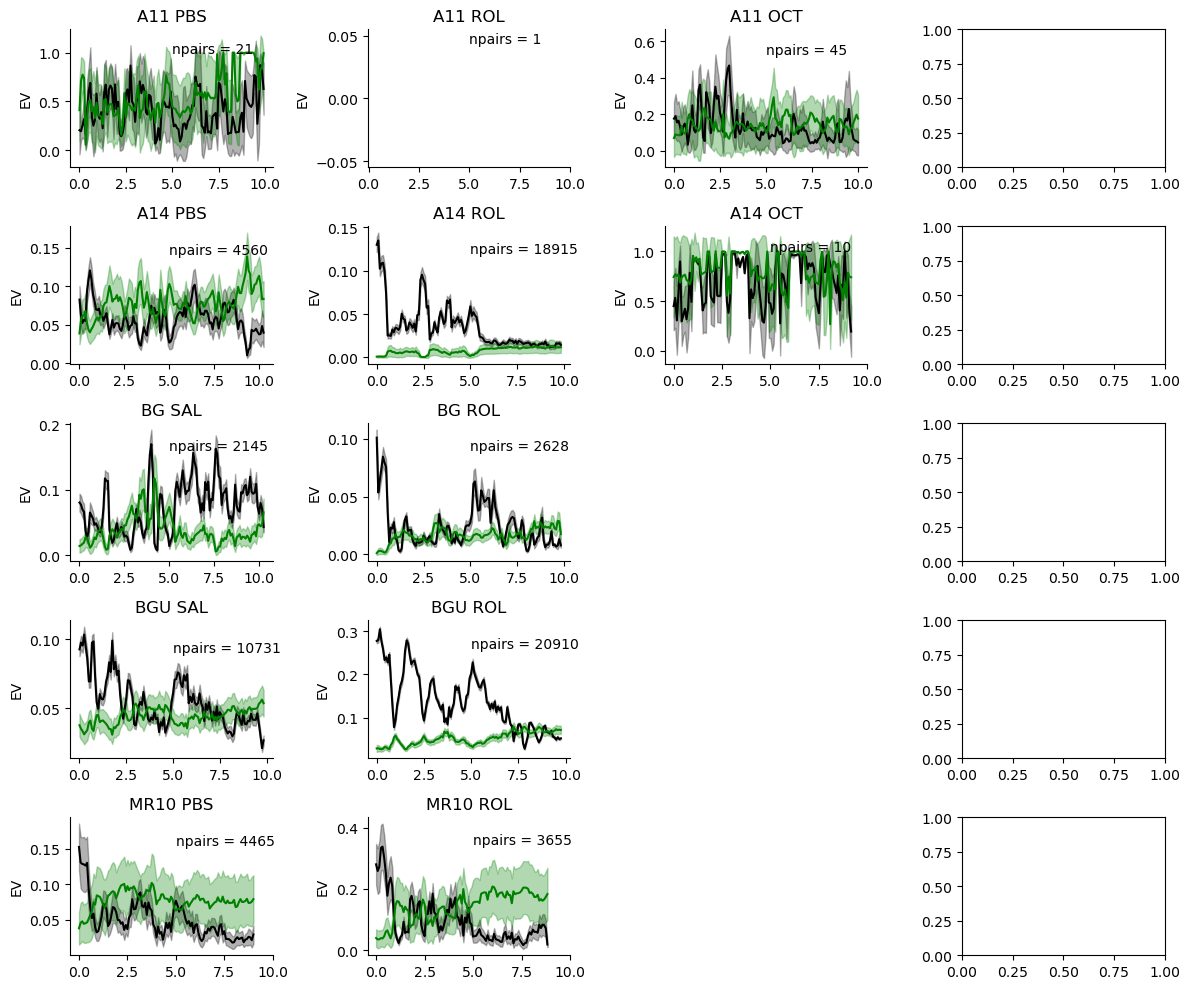

In [31]:
# nanimals = len(sesh_df.Animal.unique())
# fig, axs = plt.subplots(nanimals, 4, figsize=(12, nanimals * 2), layout='tight')

# ev_dict_all = {}
# for animal, axrow in zip(sesh_df.Animal.unique(), axs):
#     animal_df = sesh_df[sesh_df.Animal == animal]
#     for session, ax in zip(animal_df.session, axrow):
#         rec_df = animal_df[animal_df.session == session]
#         if rec_df.directory.values[0] == "None":
#             sns.despine(ax=ax, left=True, bottom=True)
#             ax.set_xticks([])
#             ax.set_yticks([])
#         else:
#             dir_use = Path(str(rec_df["directory"].values[0]))
#             neurons_use = Neurons.load(sorted(dir_use.glob("*.neurons.npy"))[0])
#             neurons_use = neurons_use.get_neuron_type(["pyr", "good", "1"])
#             # neurons_use = Neurons.from_dict(neurons_use)
#             epochs = Epoch(epochs=None, file=sorted(dir_use.glob("*.epoch.npy"))[0])
#             print(f"Running EV for {animal} {session} session")
#             ev = ExplainedVariance(neurons_use, epochs['maze'].as_array().squeeze(), [epochs['sd'].starts[0], epochs['post'].stops[0]], 
#                                    epochs['pre'].as_array().squeeze(), window=900, slideby=300, bin_size=0.250)
#             ev_dict_all[f"{animal}_{session}"] = ev
    
#             ax.plot((ev.matching_time - ev.matching_time[0])/3600, ev.ev, 'k-')
#             ax.plot((ev.matching_time - ev.matching_time[0])/3600, ev.rev, 'g-')
#             ax.fill_between((ev.matching_time - ev.matching_time[0])/3600, ev.ev - ev.ev_std, ev.ev + ev.ev_std, color='k', alpha=0.3)
#             ax.fill_between((ev.matching_time - ev.matching_time[0])/3600, ev.rev - ev.rev_std, ev.rev + ev.rev_std, color='g', alpha=0.3)
#             ax.set_title(f'{animal} {session}')
#             ax.set_xticks([0, 2.5, 5, 7.5, 10])
#             ax.set_ylabel('EV')
    
#             npairs = int(neurons_use.n_neurons*(neurons_use.n_neurons - 1) /2)
#             ax.text(5, ax.get_ylim()[1]*0.8, f"npairs = {npairs}")
#             sns.despine(ax=ax)

# fig.savefig(plot_save_dir / "EV_pyr_only.pdf")

### Run for pyr only, exclude pairs with similar waveforms

Running EV for A11 PBS sessions
Calculating partial correlations for 120 time windows


100%|█████████████████████████████████████████| 120/120 [00:16<00:00,  7.12it/s]


Running EV for A11 ROL sessions
Calculating partial correlations for 119 time windows


100%|█████████████████████████████████████████| 119/119 [00:03<00:00, 34.87it/s]
/data/GitHub/NeuroPy/neuropy/analyses/reactivation.py:194: RuntimeWarning: Mean of empty slice
  self.ev = np.nanmean(partial_corr**2, axis=0)
/data/GitHub/NeuroPy/neuropy/analyses/reactivation.py:195: RuntimeWarning: Mean of empty slice
  self.rev = np.nanmean(rev_partial_corr**2, axis=0)
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Running EV for A11 OCT sessions
Calculating partial correlations for 121 time windows


100%|█████████████████████████████████████████| 121/121 [00:19<00:00,  6.06it/s]


Running EV for A14 PBS sessions
Calculating partial correlations for 124 time windows


100%|█████████████████████████████████████████| 124/124 [00:21<00:00,  5.80it/s]


Running EV for A14 ROL sessions
Calculating partial correlations for 119 time windows


100%|█████████████████████████████████████████| 119/119 [00:23<00:00,  5.03it/s]


Running EV for A14 OCT sessions
Calculating partial correlations for 117 time windows


100%|█████████████████████████████████████████| 117/117 [00:13<00:00,  8.40it/s]
/data/GitHub/NeuroPy/neuropy/analyses/reactivation.py:194: RuntimeWarning: Mean of empty slice
  self.ev = np.nanmean(partial_corr**2, axis=0)
/data/GitHub/NeuroPy/neuropy/analyses/reactivation.py:195: RuntimeWarning: Mean of empty slice
  self.rev = np.nanmean(rev_partial_corr**2, axis=0)
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Running EV for BG SAL sessions
Calculating partial correlations for 124 time windows


100%|█████████████████████████████████████████| 124/124 [00:20<00:00,  5.93it/s]


Running EV for BG ROL sessions
Calculating partial correlations for 119 time windows


100%|█████████████████████████████████████████| 119/119 [00:20<00:00,  5.91it/s]


Running EV for BGU SAL sessions
Calculating partial correlations for 119 time windows


100%|█████████████████████████████████████████| 119/119 [00:20<00:00,  5.88it/s]


Running EV for BGU ROL sessions
Calculating partial correlations for 118 time windows


100%|█████████████████████████████████████████| 118/118 [00:18<00:00,  6.25it/s]


Running EV for MR10 PBS sessions
Calculating partial correlations for 109 time windows


100%|█████████████████████████████████████████| 109/109 [00:18<00:00,  5.85it/s]


Running EV for MR10 ROL sessions
Calculating partial correlations for 107 time windows


100%|█████████████████████████████████████████| 107/107 [00:18<00:00,  5.84it/s]


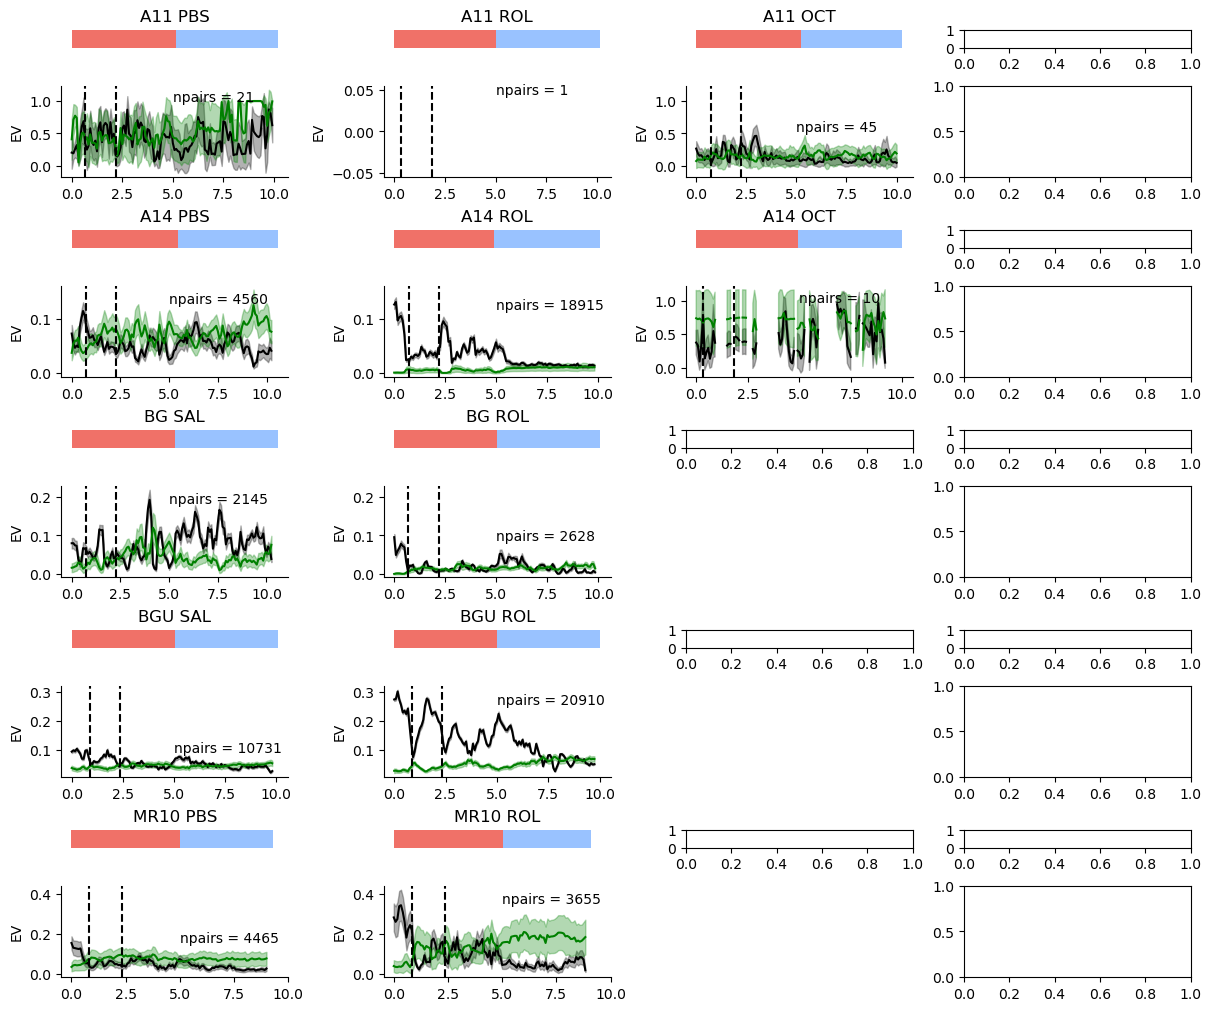

In [112]:
nanimals = len(sesh_df.Animal.unique())
# fig, axs = plt.subplots(nanimals, 4, figsize=(12, nanimals * 2), layout='tight')
fig, axs = plt.subplots(nanimals*2, 4, figsize=(12, nanimals * 2), height_ratios=[1, 5]*nanimals, layout='compressed')
plot_zeroed = True
ev_dict_all3 = {}
for animal, axrow, axepoch in zip(sesh_df.Animal.unique(), axs[1::2], axs[0::2]):
    animal_df = sesh_df[sesh_df.Animal == animal]
    axrow_used = []
    for session, ax, axe in zip(animal_df.session, axrow, axepoch):
        rec_df = animal_df[animal_df.session == session]
        if (rec_df.directory.values[0] == "None") or (rec_df.processed.values[0] == "N"):
            sns.despine(ax=ax, left=True, bottom=True)
            ax.set_xticks([])
            ax.set_yticks([])
        
        else:
            dir_use = Path(str(rec_df["directory"].values[0]))
            neurons_use = Neurons.load(sorted(dir_use.glob("*.neurons.npy"))[0])
            neurons_use = neurons_use.get_neuron_type(["pyr", "good", "1"])
            wave_similarity = neurons_use.get_waveform_similarity()
            pairs_bool = wave_similarity < 0.8
            
            epochs = Epoch(epochs=None, file=sorted(dir_use.glob("*.epoch.npy"))[0])
            print(f"Running EV for {animal} {session} sessions")
            ev = ExplainedVariance(neurons_use, epochs['maze'].as_array().squeeze(), [epochs['sd'].starts[0], epochs['post'].stops[0]], 
                                   epochs['pre'].as_array().squeeze(), window=900, slideby=300, bin_size=0.250,
                                   pairs_bool=pairs_bool)
            ev.rec_df = rec_df
            ev.epochs = epochs
            ev_dict_all3[f"{animal}_{session}"] = ev

            # Plot reactivation
            if not plot_zeroed:
                ax.plot(ev.matching_time/3600, ev.ev, 'k-')
                ax.plot(ev.matching_time/3600, ev.rev, 'g-')
                ax.fill_between(ev.matching_time/3600, ev.ev - ev.ev_std, ev.ev + ev.ev_std, color='k', alpha=0.3)
                ax.fill_between(ev.matching_time/3600, ev.rev - ev.rev_std, ev.rev + ev.rev_std, color='g', alpha=0.3)
                [ax.axvline(itime, linestyle="--", color="k") for itime in rec_df[["inject 1", "inject 2"]].values.squeeze()];
                ax.set_xticks([4, 6, 8, 10, 12, 14])
            else:
                ax.plot((ev.matching_time - ev.matching_time[0])/3600, ev.ev, 'k-')
                ax.plot((ev.matching_time - ev.matching_time[0])/3600, ev.rev, 'g-')
                ax.fill_between((ev.matching_time - ev.matching_time[0])/3600, ev.ev - ev.ev_std, ev.ev + ev.ev_std,
                                color='k', alpha=0.3)
                ax.fill_between((ev.matching_time - ev.matching_time[0])/3600, ev.rev - ev.rev_std, ev.rev + ev.rev_std, 
                                color='g', alpha=0.3)
                [ax.axvline(itime, linestyle="--", color="k") for itime in 
                 rec_df[["inject 1", "inject 2"]].values.squeeze() - ev.matching_time[0]/3600];
                ax.set_xticks([0, 2.5, 5, 7.5, 10])
            axe.set_title(f'{animal} {session}')
            
            ax.set_ylabel('EV')

            # Plot epochs
            if not plot_zeroed:
                plot_epochs(epochs[["sd", "post"]].scale(1/3600), collapsed=True, colors=colors_all_light[2:], ax=axe)
            else:
                epochs_zeroed = epochs[["sd", "post"]].scale(1/3600).shift(-epochs["sd"].scale(1/3600).starts[0])
                plot_epochs(epochs_zeroed, collapsed=True, colors=colors_all_light[2:], ax=axe)
            
            npairs = int(neurons_use.n_neurons*(neurons_use.n_neurons - 1) /2)
            ax.text(5, ax.get_ylim()[1]*0.8, f"npairs = {npairs}")
            sns.despine(ax=ax)
            sns.despine(ax=axe, left=True, bottom=True)
            axe.set_xticks([])
            axe.set_yticks([])

            if npairs > 20:
                axrow_used.append(ax)

            match_axis_lims([ax, axe], "x")

    # Match y limits on all EV plots in a row
    match_axis_lims(axrow_used, "y")

fig.savefig(plot_save_dir / "EV_pyr_only_wave_exclude.pdf")

In [213]:
def ev_weighted_average(ev_dict, sess_type: str in ["PBS/SAL", "ROL", "OCT"], method: str in ['mean', 'wmean'] = 'wmean'):
    sess_type = ["PBS", "SAL"] if (sess_type == "PBS") | (sess_type == "SAL") | (sess_type == "PBS/SAL") else [sess_type]
    
    # Grab appropriate sessions and get nbins to use
    ev_by_sess_use, nbins= [], []
    for sess_name, ev_use in ev_dict_all3.items():
        if sess_name.split("_")[1] in sess_type:
            # print(sess_name)
            ev_by_sess_use.append(ev_use)
            nbins.append(ev_use.matching_time.shape[0])
    nbins = np.max(nbins)
    nsesh = len(ev_by_sess_use)

    # Aggregate aligned data
    ev_comb, rev_comb, t_comb = np.ones((nsesh, nbins))*np.nan, np.ones((nsesh, nbins))*np.nan, np.ones((nsesh, nbins))*np.nan
    ev_std_comb, rev_std_comb = np.ones((nsesh, nbins))*np.nan, np.ones((nsesh, nbins))*np.nan
    npairs, sd_stop, inj_times_all = [], [], []
    ev_error = []
    assert len(set([_.slideby for _ in ev_by_sess_use])) and len(set([_.window for _ in ev_by_sess_use])), "All sessions must use the same slideby and window"
    for ids, ev_use in enumerate(ev_by_sess_use):
        idt = ((ev_use.matching_time - ev_use.matching_time[0])/ev_use.slideby).astype(int)
        ev_comb[ids, idt] = ev_use.ev
        rev_comb[ids, idt] = ev_use.rev
        t_comb[ids, idt] = (ev_use.matching_time - ev_use.matching_time[0])/3600
    
        ev_std_comb[ids, idt] = ev_use.ev_std
        rev_std_comb[ids, idt] = ev_use.rev_std
        npairs.append(ev_use.n_pairs)
        try:
            print(ev_use.epochs)  # Super weird error here I can't figure out - maybe a restart will fix?
        except TypeError:
            ev_error.append(ev_use)
            
        # sd_stop.append(ev_use.epochs["sd"].starts[0] - ev_use.epochs["maze"].stops[0])/3600
        inj_times_all.append(ev_use.rec_df[["inject 1", "inject 2"]].values.squeeze() - ev_use.matching_time[0]/3600)
    
    # Calculate weighted mean and std.
    assert method in ['mean', 'wmean']
    if method == 'wmean':

        # Doesn't work with nans!
        # ev_wmean = np.average(ev_comb, axis=0, weights=npairs)
        # rev_wmean = np.average(rev_comb, axis=0, weights=npairs)
        ev_wmean = np.nansum(ev_comb*np.array(npairs)[:, None], axis=0)/np.sum(npairs)
        rev_wmean = np.nansum(rev_comb*np.array(npairs)[:, None], axis=0)/np.sum(npairs)
        
        ev_std_wmean = np.sqrt(np.nansum(np.square(ev_std_comb)*np.array(npairs)[:, None], axis=0)/np.sum(npairs))
        rev_std_wmean = np.sqrt(np.nansum(np.square(rev_std_comb)*np.array(npairs)[:, None], axis=0)/np.sum(npairs))
    else:
        ev_wmean =  np.nanmean(ev_comb, axis=0)
        rev_wmean = np.nanmean(rev_comb, axis=0)
        
        ev_std_wmean = np.nanmean(ev_std_comb, axis=0)
        rev_std_wmean = np.nanmean(rev_std_comb, axis=0)

    t_use = np.nanmean(t_comb, axis=0)

    
    # NRK add in injection times and epochs for averaging!

    return t_use, ev_wmean, rev_wmean, ev_std_wmean, rev_std_wmean, np.mean(sd_stop), np.mean(inj_times_all, axis=0)

t_use, ev_wmean, rev_wmean, ev_std_wmean, rev_std_wmean, sd_stop_mean, inj_mean = ev_weighted_average(ev_dict_all3, "ROL")

/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site

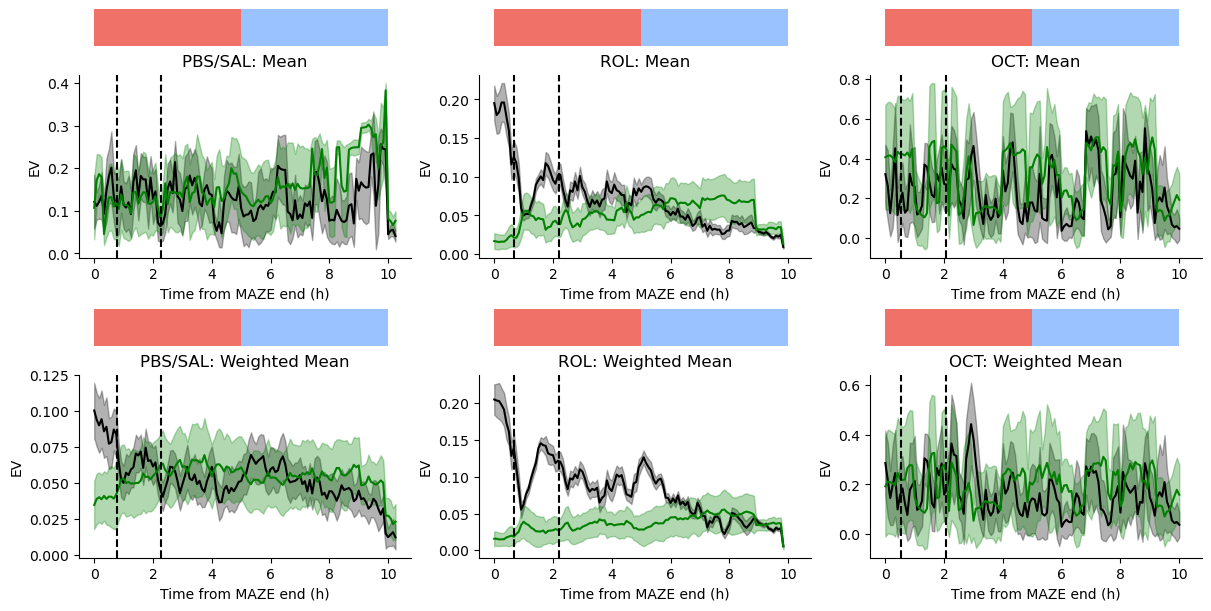

In [232]:
def plot_ev_comb(ev_plot, rev_plot, ev_std_plot, rev_std_plot, t_plot, inj_mean: None or list = None, ax=None):

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(6, 3))

    t_use = np.nanmean(t_comb, axis=0)

    ax.plot(t_plot, ev_plot, 'k-')
    ax.plot(t_plot, rev_plot, 'g-')

    ax.fill_between(t_plot, ev_plot - ev_std_plot, ev_plot + ev_std_plot, color='k', alpha=0.3)
    ax.fill_between(t_plot, rev_plot - rev_std_plot, rev_plot + rev_std_plot, color='g', alpha=0.3)

    if inj_mean is not None:
        [ax.axvline(itime, linestyle="--", color="k") for itime in inj_mean]
    
    sns.despine(ax=ax)

    ax.set_ylabel("EV")
    ax.set_xlabel("Time from MAZE end (h)")

    return ax

/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site

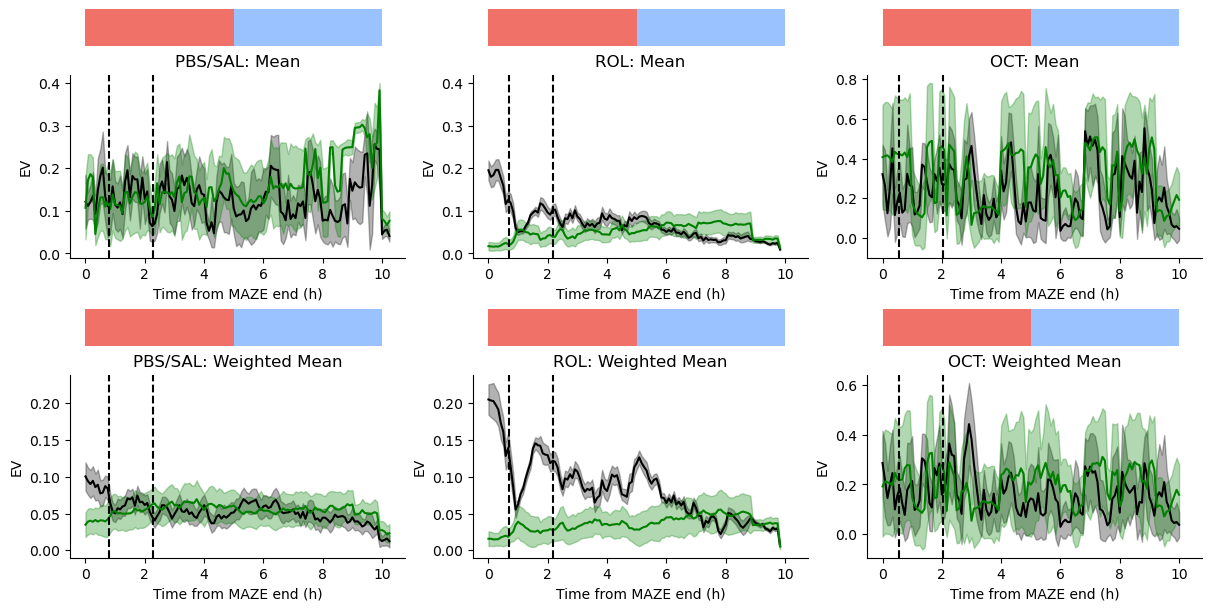

In [235]:
fig, ax = plt.subplots(4, 3, figsize=(12, 6), height_ratios=[1, 5, 1, 5], layout='compressed')

sd_stop = 5  # pretty consistent, just hard-code
epochs_mean = Epoch(pd.DataFrame({"start": [0, sd_stop], "stop": [sd_stop, 10], "label": ["sd", "post"]}))
for arow1, arow2, method, title in zip(ax[0::2], ax[1::2], ["mean", "wmean"], ["Mean", "Weighted Mean"]):
    for aepoch, a, sesh_type in zip(arow1, arow2, ["PBS/SAL", "ROL", "OCT"]):
        t_use, ev_wmean, rev_wmean, ev_std_wmean, rev_std_wmean, sd_stop_mean, inj_mean = ev_weighted_average(ev_dict_all3, sesh_type, method=method)
        plot_ev_comb(ev_wmean, rev_wmean, ev_std_wmean, rev_std_wmean, t_use, inj_mean, ax=a)
        a.set_title(f"{sesh_type}: {title}")
        
        plot_epochs(epochs_mean, collapsed=True, colors=colors_all_light[2:], ax=aepoch)
        sns.despine(ax=aepoch, left=True, bottom=True)
        aepoch.set_xticks([])
        aepoch.set_yticks([])
    match_axis_lims(arow2[0:2], "y")

match_axis_lims(ax.reshape(-1), "x")

fig.savefig(plot_save_dir / "EV_pyr_only_wave_exclude_combined.pdf")

In [ ]:
# nanimals = len(sesh_df.Animal.unique())
# fig, axs = plt.subplots(nanimals, 4, figsize=(12, nanimals * 2), layout='tight')

# ev_dict_all = {}
# for animal, axrow in zip(sesh_df.Animal.unique(), axs):
#     animal_df = sesh_df[sesh_df.Animal == animal]
#     for session, ax in zip(animal_df.session, axrow):
#         rec_df = animal_df[animal_df.session == session]
#         if rec_df.directory.values[0] == "None":
#             sns.despine(ax=ax, left=True, bottom=True)
#             ax.set_xticks([])
#             ax.set_yticks([])
#         else:
#             dir_use = Path(str(rec_df["directory"].values[0]))
            
#             neurons_use = Neurons.load(sorted(dir_use.glob("*.neurons.npy"))[0])
#             neurons_use = neurons_use.get_neuron_type(["pyr", "good", "1"])
#             wave_similarity = neurons_use.get_waveform_similarity()
#             pairs_bool = wave_similarity < 0.8
            
#             epochs = Epoch(epochs=None, file=sorted(dir_use.glob("*.epoch.npy"))[0])
#             print(f"Running EV for {animal} {session} session")
#             ev = ExplainedVariance(neurons_use, epochs['maze'].as_array().squeeze(), [epochs['sd'].starts[0], epochs['post'].stops[0]], 
#                                    epochs['pre'].as_array().squeeze(), window=900, slideby=300, bin_size=0.250,
#                                    pairs_bool=pairs_bool)
#             ev_dict_all[f"{animal}_{session}"] = ev
    
#             ax.plot((ev.matching_time - ev.matching_time[0])/3600, ev.ev, 'k-')
#             ax.plot((ev.matching_time - ev.matching_time[0])/3600, ev.rev, 'g-')
#             ax.fill_between((ev.matching_time - ev.matching_time[0])/3600, ev.ev - ev.ev_std, ev.ev + ev.ev_std, color='k', alpha=0.3)
#             ax.fill_between((ev.matching_time - ev.matching_time[0])/3600, ev.rev - ev.rev_std, ev.rev + ev.rev_std, color='g', alpha=0.3)
#             ax.set_title(f'{animal} {session}')
#             ax.set_xticks([0, 2.5, 5, 7.5, 10])
#             ax.set_ylabel('EV')
    
#             # npairs = int(neurons_use.n_neurons*(neurons_use.n_neurons - 1) /2)
#             npairs = int(np.triu(pairs_bool, 1).reshape(-1).sum())
#             ax.text(5, ax.get_ylim()[1]*0.8, f"npairs = {npairs}")
#             sns.despine(ax=ax)

# fig.savefig(plot_save_dir / "EV_pyr_only_wave_exclude.pdf")

In [1]:
neurons_use

NameError: name 'neurons_use' is not defined

In [ ]:
neurons_use = Neurons.load(sorted(dir_use.glob("*.neurons.npy"))[0])
neurons_use.get_neuron_type(["1", "pyr"]).neuron_type

In [ ]:
fig, axs = plt.subplots(nanimals, 4, figsize=(12, nanimals * 2))
npairs = int(neurons_use.n_neurons*(neurons_use.n_neurons - 1) /2)
sns.despine(ax=axs[1][1], left=True, bottom=True)
axs[1][1].set_xticks([])
axs[1][1].set_yticks([])